# 데이터 임포트

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
! mkdir data
# ! unzip /content/drive/MyDrive/projects/oden_anomalydetection/wando_sample.zip -d data

mkdir: cannot create directory ‘data’: File exists


In [1]:
import pandas as pd
import ast

In [2]:
# df1 = pd.read_excel("data/wando1_oxygen(9.15~10.14).xlsx")
# df2 = pd.read_excel("data/wando2_oxygen(8.15~9.15).xlsx")
# df3 = pd.read_excel("data/wando2_oxygen(9.15~10.14).xlsx")

# df1 = pd.read_excel("/content/drive/MyDrive/wando01b_oxygen(10.23-11.1).xlsx")
# df2 = pd.read_excel("/content/drive/MyDrive/wando1_oxygen(5.23-11.1).xlsx")
# df3 = pd.read_excel("/content/drive/MyDrive/wando2_oxygen(8.15~11.1).xlsx")

df1 = pd.read_excel("E:/경북대/3학년 2학기/design1/biocode/11-03data/wando01.xlsx")
df2 = pd.read_excel("E:/경북대/3학년 2학기/design1/biocode/11-03data/wando01b.xlsx")
df3 = pd.read_excel("E:/경북대/3학년 2학기/design1/biocode/11-03data/wando02.xlsx")

In [3]:
df = pd.concat([df1, df2, df3]).reset_index(drop=True)

In [4]:
df.isnull().sum()

device_id        0
device_type      0
measure_time     0
serial_number    0
coordinates      0
temperature      0
oxygen_mpl       0
oxygen_per       0
oxygen_ppm       0
date_time        0
dtype: int64

In [5]:
df.duplicated().sum()

0

# 데이터 전처리 및 EDA

In [6]:
import matplotlib.pyplot as plt

In [7]:
df.columns

Index(['device_id', 'device_type', 'measure_time', 'serial_number',
       'coordinates', 'temperature', 'oxygen_mpl', 'oxygen_per', 'oxygen_ppm',
       'date_time'],
      dtype='object')

In [8]:
df = df[['device_id', 'date_time', 'temperature', 'oxygen_ppm']]

In [9]:
df['date_time'] = pd.to_datetime(df['date_time'])

In [10]:
col_li = ['temperature', 'oxygen_ppm']

In [11]:
for col in col_li:
  df[col] = df[col].apply(ast.literal_eval)
  df[col] = df[col].apply(lambda x: x['value'])

In [12]:
df.dtypes

device_id              object
date_time      datetime64[ns]
temperature           float64
oxygen_ppm            float64
dtype: object

In [13]:
pd.to_datetime(df['date_time'])

0        2024-05-23 02:18:28
1        2024-05-23 02:20:00
2        2024-05-23 02:21:33
3        2024-05-23 02:23:05
4        2024-05-23 02:28:28
                 ...        
327367   2024-11-03 05:21:23
327368   2024-11-03 05:23:37
327369   2024-11-03 05:24:42
327370   2024-11-03 05:25:46
327371   2024-11-03 05:26:50
Name: date_time, Length: 327372, dtype: datetime64[ns]

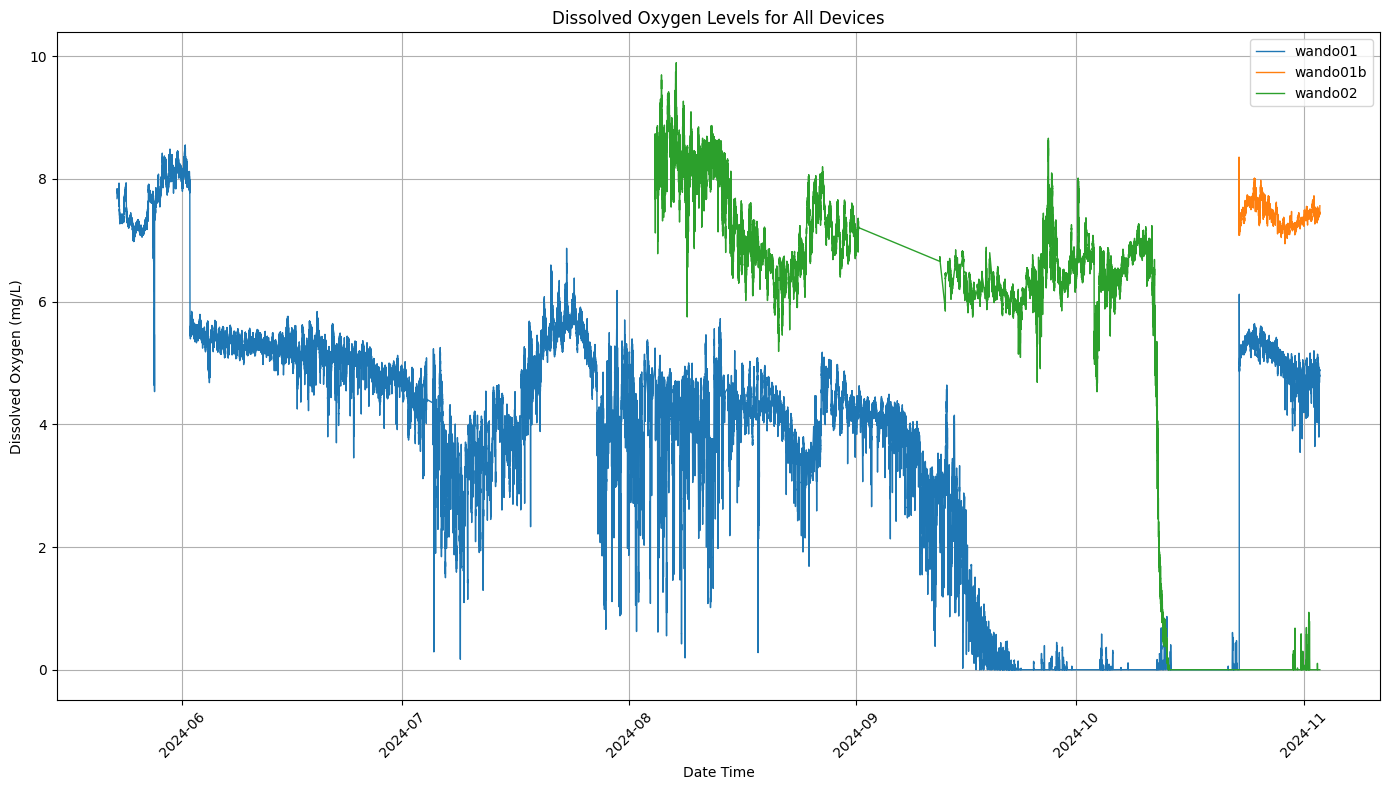

In [14]:
import matplotlib.pyplot as plt

# 그래프 설정
plt.figure(figsize=(14, 8))

# 전체 데이터를 디바이스별로 시각화
for device_id in df['device_id'].unique():
    device_data = df[df['device_id'] == device_id]

    # 모든 데이터 시각화
    plt.plot(device_data['date_time'], device_data['oxygen_ppm'], label=f'{device_id}', linewidth=1)

# 그래프 세부 설정
plt.title('Dissolved Oxygen Levels for All Devices')
plt.xlabel('Date Time')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


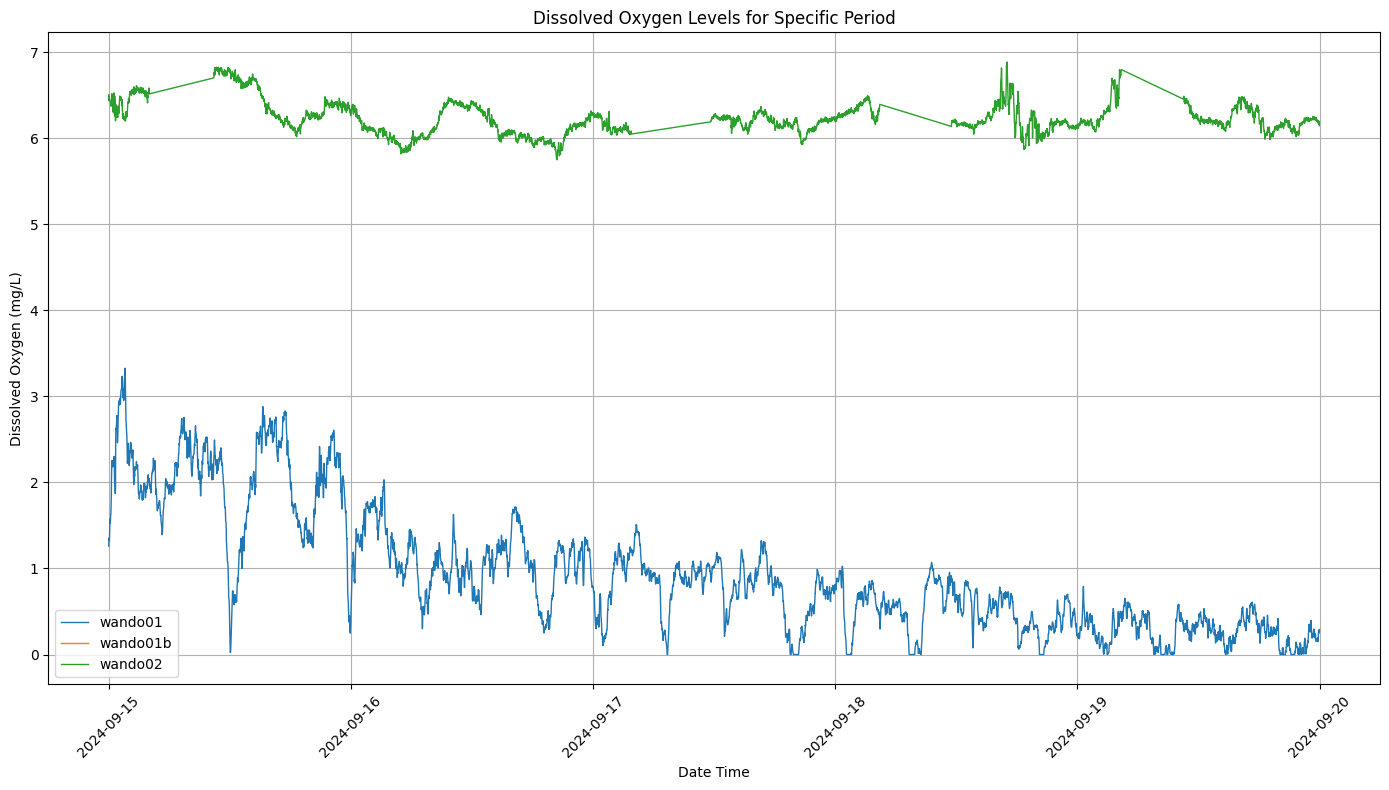

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# 특정 기간 설정 (예시: 2024-09-01 ~ 2024-10-15)
start_date = pd.Timestamp('2024-9-15')
end_date = pd.Timestamp('2024-9-20')

# 그래프 설정
plt.figure(figsize=(14, 8))

# 특정 기간 동안의 데이터를 각 디바이스별로 시각화
for device_id in df['device_id'].unique():
    device_data = df[(df['device_id'] == device_id) & (df['date_time'] >= start_date) & (df['date_time'] <= end_date)]

    # 전체 데이터 시각화
    plt.plot(device_data['date_time'], device_data['oxygen_ppm'], label=f'{device_id}', linewidth=1)

# 그래프 세부 설정
plt.title('Dissolved Oxygen Levels for Specific Period')
plt.xlabel('Date Time')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [16]:
import pandas as pd

# 초기화: 비정상 여부를 나타내는 열을 0으로 설정
df['is_abnormal'] = 0

# 3.0 이하로 떨어지는 구간 식별 및 비정상 데이터 정의
df['is_below_3'] = (df['oxygen_ppm'] <= 3.0)

# 3.0 이하로 처음 도달한 지점 식별
df['first_below_3'] = df['is_below_3'] & ~df['is_below_3'].shift().fillna(False)

# 첫 도달 지점에 대해 비정상 라벨링 및 이전 719개 데이터까지 포함
for index in df[df['first_below_3']].index:
    start_index = max(0, index - 719)
    df.loc[start_index:index, 'is_abnormal'] = 1  # 비정상 라벨링

# 비정상 인덱스를 마커로 생성
df['abnormal_index'] = df['is_abnormal'].cumsum()

# 각 비정상 데이터에 대해 719개 전까지 라벨링
df['is_abnormal'] = df['is_abnormal'].rolling(window=720, min_periods=1).max()

# 마커 열 삭제
df.drop(columns=['abnormal_index', 'is_below_3', 'first_below_3'], inplace=True)

# 결과 확인
print("Updated abnormal data labeling (optimized):")
print(df[df['is_abnormal'] == 1].head())


Updated abnormal data labeling (optimized):
      device_id           date_time  temperature  oxygen_ppm  is_abnormal
54554   wando01 2024-07-03 21:54:27    23.623495    4.282974          1.0
54555   wando01 2024-07-03 21:55:32    23.641720    4.284094          1.0
54556   wando01 2024-07-03 21:56:36    23.599964    4.265943          1.0
54557   wando01 2024-07-03 21:57:40    23.353756    4.223091          1.0
54558   wando01 2024-07-03 21:58:45    23.236752    4.286205          1.0


C:\Users\lgiht\AppData\Local\Temp\ipykernel_42132\281660313.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['first_below_3'] = df['is_below_3'] & ~df['is_below_3'].shift().fillna(False)


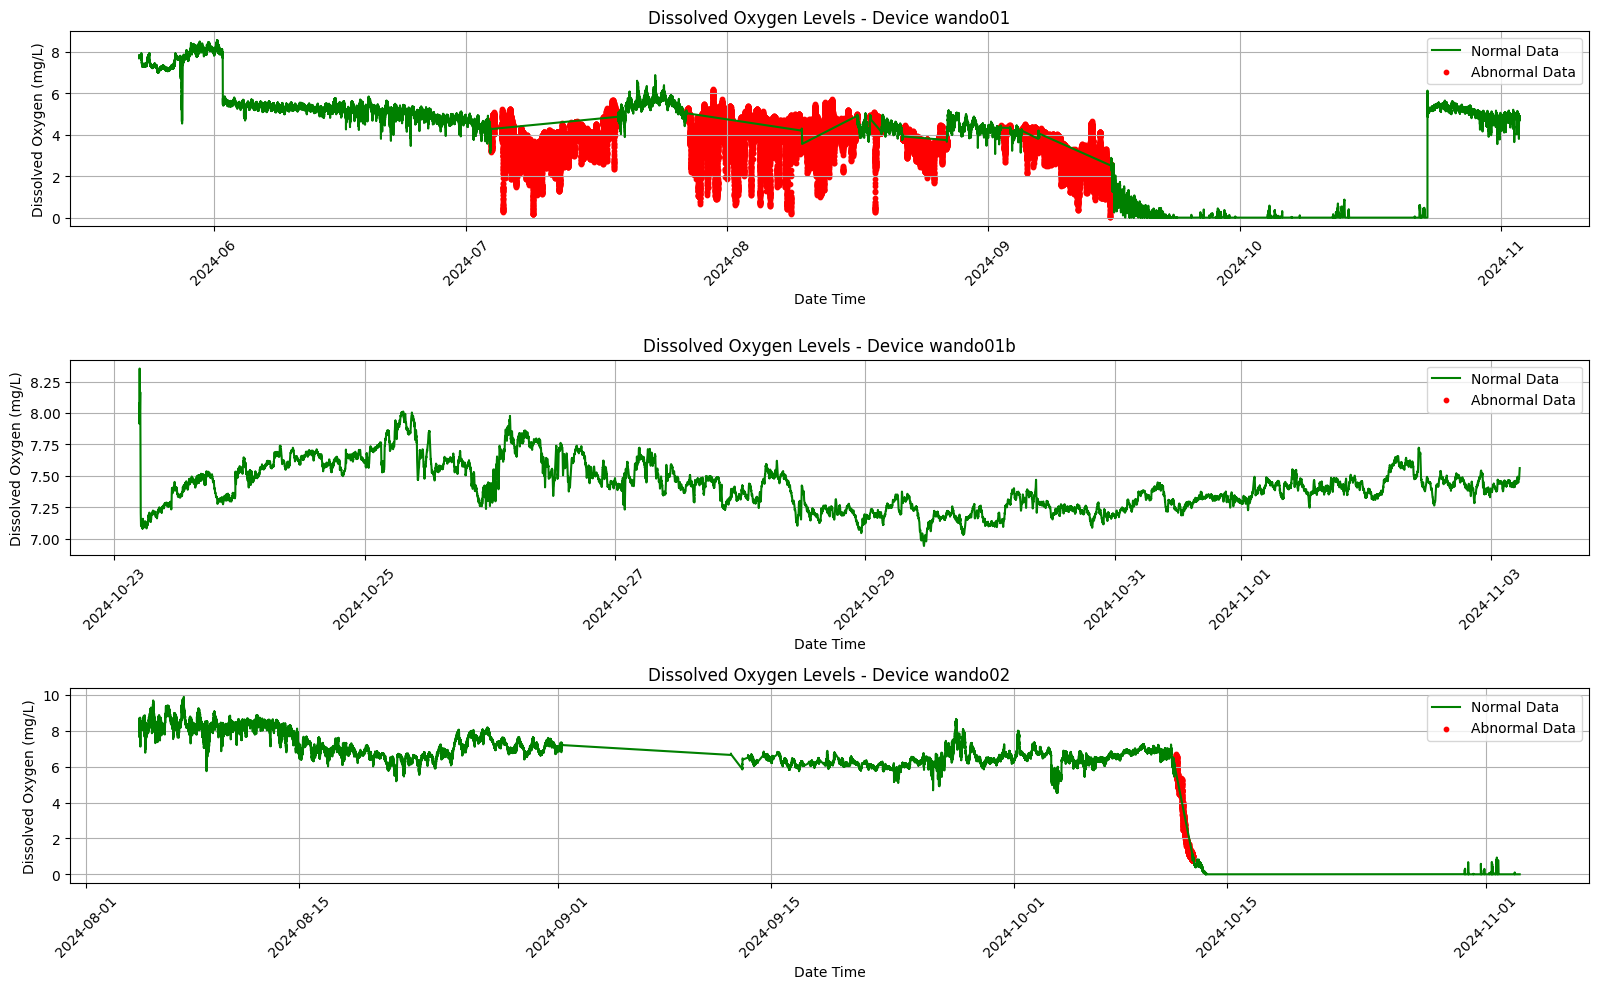

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# 디바이스별로 데이터 분리
device_ids = df['device_id'].unique()

# 그래프 설정
plt.figure(figsize=(16, 10))

for i, device_id in enumerate(device_ids, 1):
    # 디바이스별 데이터 필터링
    device_data = df[df['device_id'] == device_id]

    # 정상 데이터와 비정상 구간 필터링
    normal_data = device_data[device_data['is_abnormal'] == 0]
    abnormal_data = device_data[device_data['is_abnormal'] == 1]

    # 각 디바이스에 대한 서브플롯 생성
    plt.subplot(len(device_ids), 1, i)
    plt.plot(normal_data['date_time'], normal_data['oxygen_ppm'], label='Normal Data', color='green')
    plt.scatter(abnormal_data['date_time'], abnormal_data['oxygen_ppm'], color='red', label='Abnormal Data', s=10)

    # 그래프 세부 설정
    plt.title(f'Dissolved Oxygen Levels - Device {device_id}')
    plt.xlabel('Date Time')
    plt.ylabel('Dissolved Oxygen (mg/L)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


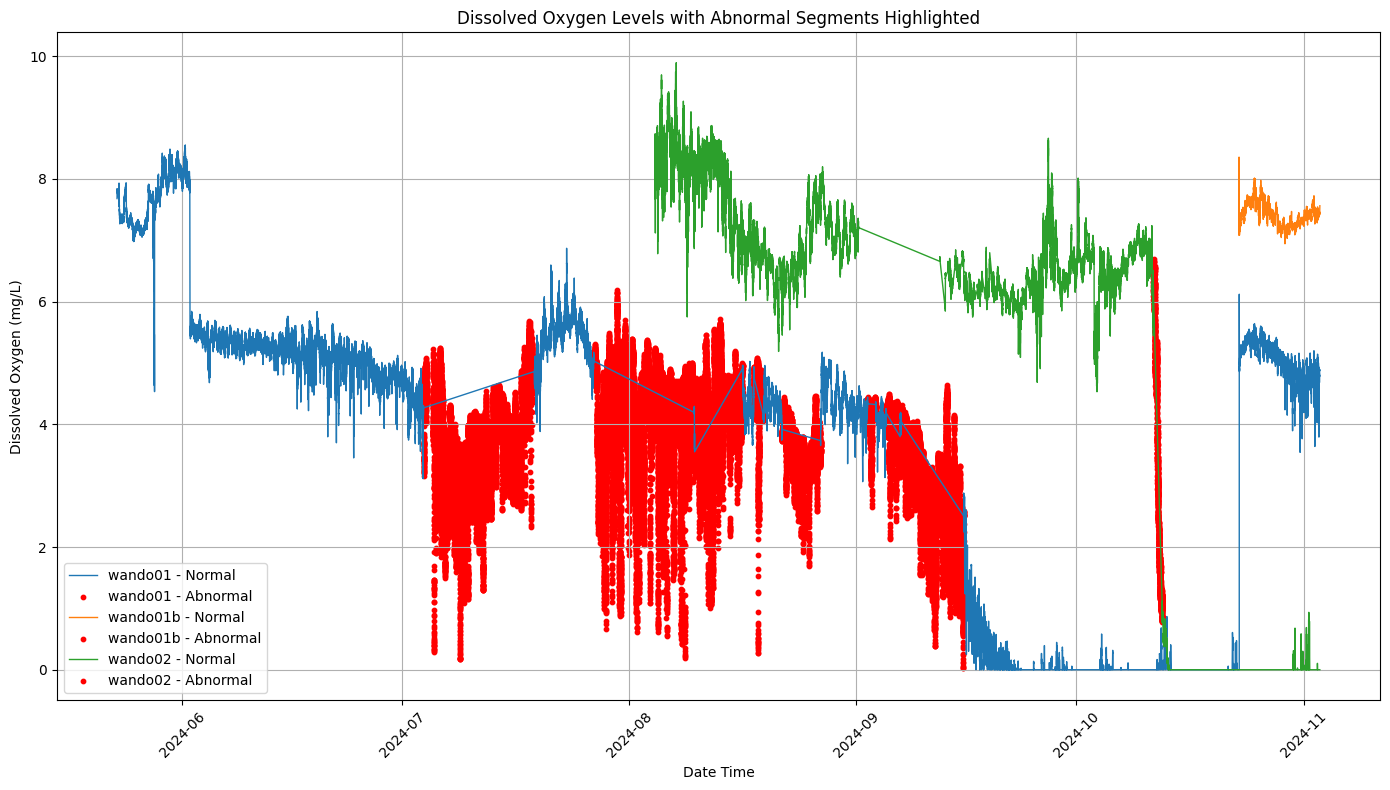

In [18]:
import matplotlib.pyplot as plt

# 그래프 설정
plt.figure(figsize=(14, 8))

# 전체 데이터를 정상/비정상 구분하여 시각화
for device_id in df['device_id'].unique():
    device_data = df[df['device_id'] == device_id]

    # 정상 구간
    normal_data = device_data[device_data['is_abnormal'] == 0]
    plt.plot(normal_data['date_time'], normal_data['oxygen_ppm'], label=f'{device_id} - Normal', linewidth=1)

    # 비정상 구간
    abnormal_data = device_data[device_data['is_abnormal'] == 1]
    plt.scatter(abnormal_data['date_time'], abnormal_data['oxygen_ppm'], label=f'{device_id} - Abnormal', color='red', s=10)

# 그래프 세부 설정
plt.title('Dissolved Oxygen Levels with Abnormal Segments Highlighted')
plt.xlabel('Date Time')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [19]:
print(len(df))

327372


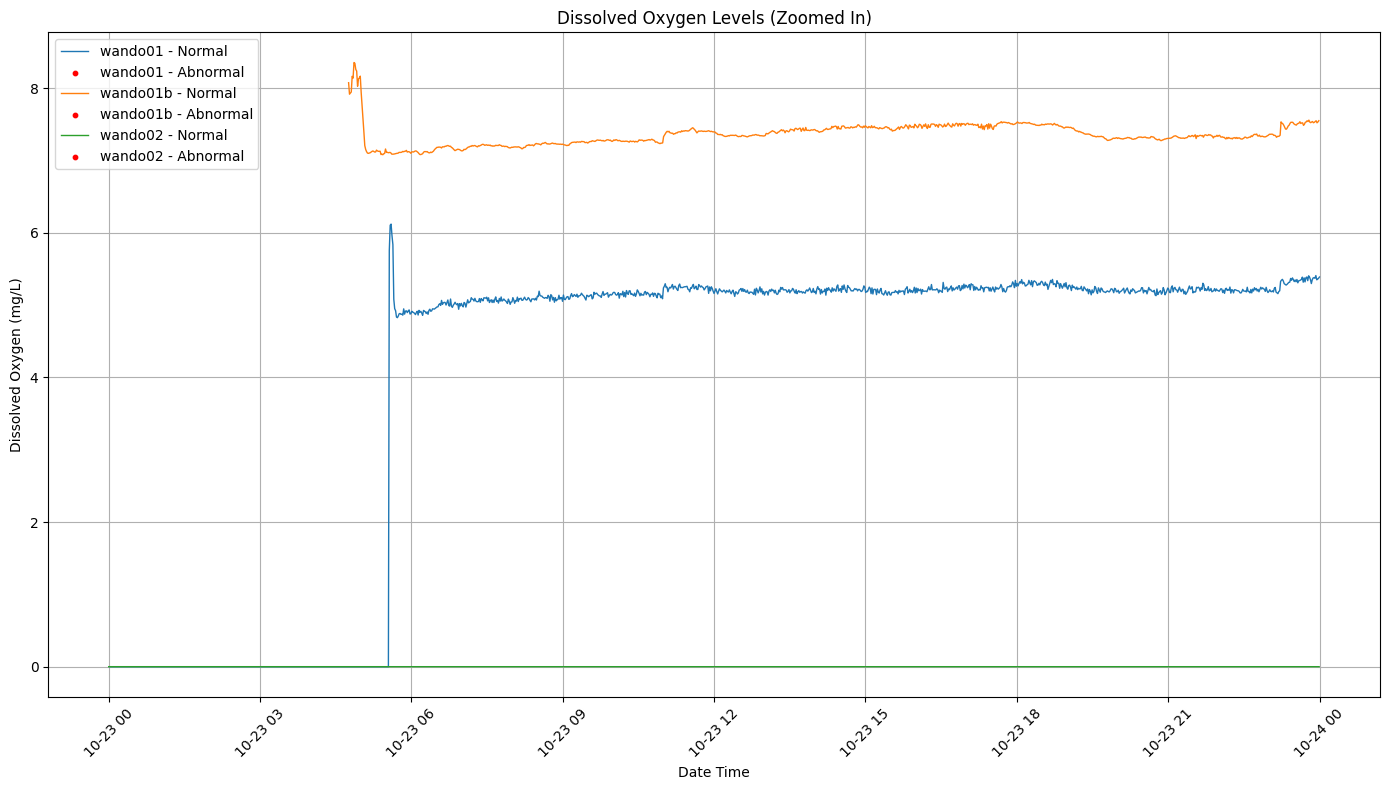

In [20]:
#특정 기간 확대하여 보는 코드

import matplotlib.pyplot as plt
import pandas as pd

# 특정 구간 확대 설정 (예: 9월 16일 이후의 일부분을 확대)
# 확대할 날짜 범위 (필요에 따라 조정 가능)
zoom_start_date = pd.Timestamp('2024-10-23')
zoom_end_date = pd.Timestamp('2024-10-24')

# 데이터 필터링: 확대할 날짜 범위에 해당하는 데이터만 선택
zoomed_data = df[(df['date_time'] >= zoom_start_date) & (df['date_time'] <= zoom_end_date)]

# 그래프 설정
plt.figure(figsize=(14, 8))

# 전체 데이터를 시각화하되, 급격한 감소 패턴을 가진 구간은 별도 색상으로 표시
for device_id in zoomed_data['device_id'].unique():
    device_data = zoomed_data[zoomed_data['device_id'] == device_id]

    # 정상 구간
    normal_data = device_data[(device_data['is_abnormal'] == 0)]
    plt.plot(normal_data['date_time'], normal_data['oxygen_ppm'], label=f'{device_id} - Normal', linewidth=1)

    # 비정상 구간
    abnormal_data = device_data[device_data['is_abnormal'] == 1]
    plt.scatter(abnormal_data['date_time'], abnormal_data['oxygen_ppm'], label=f'{device_id} - Abnormal', color='red', s=10)

# 그래프 세부 설정
plt.title('Dissolved Oxygen Levels (Zoomed In)')
plt.xlabel('Date Time')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [21]:
import pandas as pd

# 특정 기간 데이터 삭제 (완도1: 9월 15일 18:00 ~ 10월 23일 06:00)
start_exclude_wando01 = pd.Timestamp('2024-09-15 18:00:00')
end_exclude_wando01 = pd.Timestamp('2024-10-23 06:00:00')
df = df[~((df['device_id'] == 'wando01') & (df['date_time'].between(start_exclude_wando01, end_exclude_wando01)))]

# 특정 기간 데이터 삭제 (완도2: 10월 12일 18:00부터 이후)
start_exclude_wando02 = pd.Timestamp('2024-10-12 18:00:00')
df = df[~((df['device_id'] == 'wando02') & (df['date_time'] >= start_exclude_wando02))]

# 결과 확인
print("Data after excluding specific periods:")
print(df.head())


Data after excluding specific periods:
  device_id           date_time  temperature  oxygen_ppm  is_abnormal
0   wando01 2024-05-23 02:18:28    23.655396    7.678514          0.0
1   wando01 2024-05-23 02:20:00    23.655336    7.711918          0.0
2   wando01 2024-05-23 02:21:33    23.651709    7.787882          0.0
3   wando01 2024-05-23 02:23:05    23.648855    7.827593          0.0
4   wando01 2024-05-23 02:28:28    23.655128    7.751092          0.0


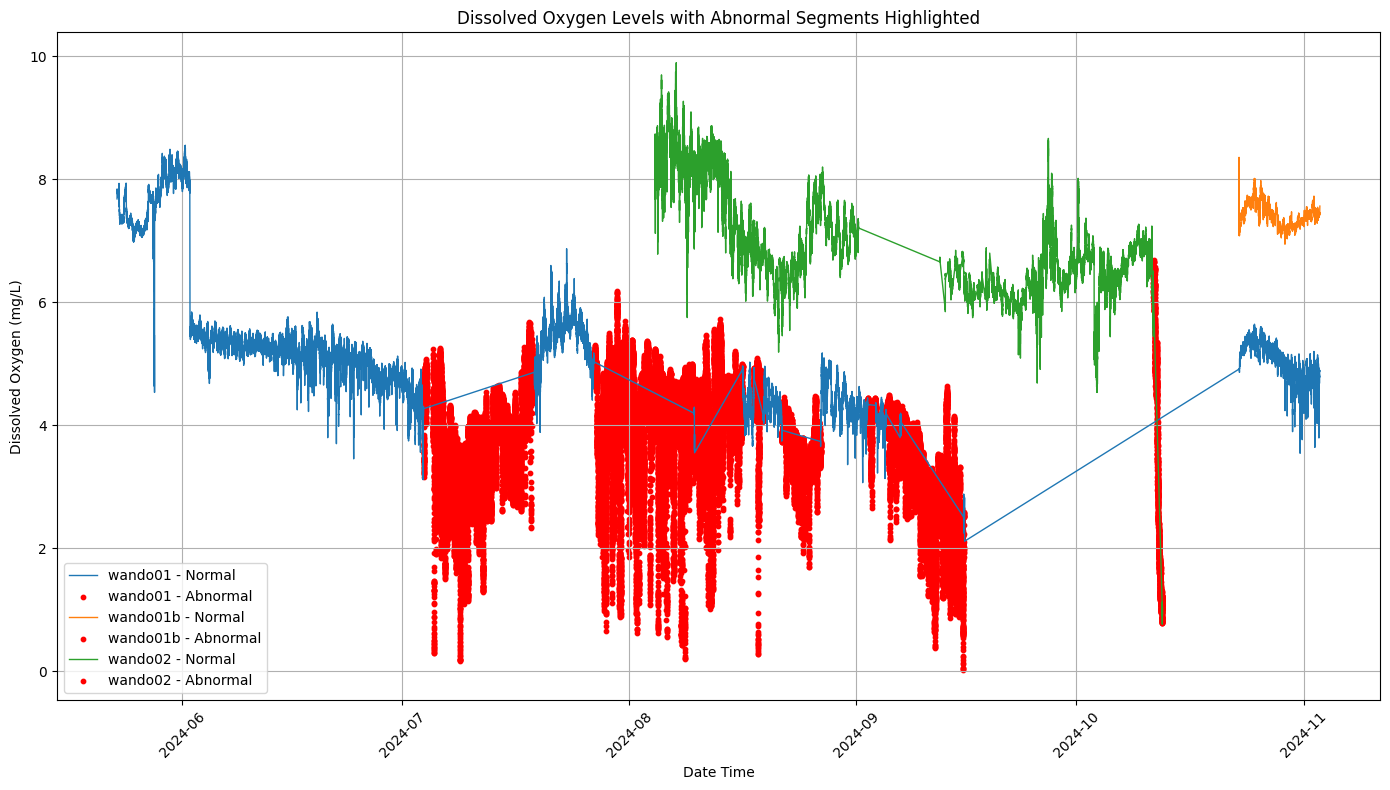

In [22]:
import matplotlib.pyplot as plt

# 그래프 설정
plt.figure(figsize=(14, 8))

# 전체 데이터를 정상/비정상 구분하여 시각화
for device_id in df['device_id'].unique():
    device_data = df[df['device_id'] == device_id]

    # 정상 구간
    normal_data = device_data[device_data['is_abnormal'] == 0]
    plt.plot(normal_data['date_time'], normal_data['oxygen_ppm'], label=f'{device_id} - Normal', linewidth=1)

    # 비정상 구간
    abnormal_data = device_data[device_data['is_abnormal'] == 1]
    plt.scatter(abnormal_data['date_time'], abnormal_data['oxygen_ppm'], label=f'{device_id} - Abnormal', color='red', s=10)

# 그래프 세부 설정
plt.title('Dissolved Oxygen Levels with Abnormal Segments Highlighted')
plt.xlabel('Date Time')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [23]:
# abnormal_df = df[df['device_id']=="wando01"].reset_index(drop=True)
# normal_df = df[df['device_id']=="wando02"].reset_index(drop=True)

# 기존 normal_df와 abnormal_df를 유지하면서 디바이스별 데이터를 처리
normal_df = df[df['is_abnormal'] == 0].reset_index(drop=True)
abnormal_df = df[df['is_abnormal'] == 1].reset_index(drop=True)

for device_id in df['device_id'].unique():
    device_data = df[df['device_id'] == device_id]

    # 디바이스별 정상 및 비정상 데이터 추출
    device_normal_df = device_data[device_data['is_abnormal'] == 0].reset_index(drop=True)
    device_abnormal_df = device_data[device_data['is_abnormal'] == 1].reset_index(drop=True)

    # 디바이스별 정상 및 비정상 데이터 출력
    print(f"Device ID: {device_id}")
    print("Normal Data Sample for this device:")
    print(device_normal_df.head(), "\n")
    print("Abnormal Data Sample for this device:")
    print(device_abnormal_df.head(), "\n")

# 최종 전체 데이터 유지
print("Combined Normal Data Sample (existing normal_df):")
print(normal_df.head())
print("\nCombined Abnormal Data Sample (existing abnormal_df):")
print(abnormal_df.head())

Device ID: wando01
Normal Data Sample for this device:
  device_id           date_time  temperature  oxygen_ppm  is_abnormal
0   wando01 2024-05-23 02:18:28    23.655396    7.678514          0.0
1   wando01 2024-05-23 02:20:00    23.655336    7.711918          0.0
2   wando01 2024-05-23 02:21:33    23.651709    7.787882          0.0
3   wando01 2024-05-23 02:23:05    23.648855    7.827593          0.0
4   wando01 2024-05-23 02:28:28    23.655128    7.751092          0.0 

Abnormal Data Sample for this device:
  device_id           date_time  temperature  oxygen_ppm  is_abnormal
0   wando01 2024-07-03 21:54:27    23.623495    4.282974          1.0
1   wando01 2024-07-03 21:55:32    23.641720    4.284094          1.0
2   wando01 2024-07-03 21:56:36    23.599964    4.265943          1.0
3   wando01 2024-07-03 21:57:40    23.353756    4.223091          1.0
4   wando01 2024-07-03 21:58:45    23.236752    4.286205          1.0 

Device ID: wando01b
Normal Data Sample for this device:
  devic

In [24]:
#전체 데이터 개수를 확인하는 코드

print(f"전체 데이터 개수: {len(df)}")
print(f"abnormal 데이터 개수: {len(abnormal_df)}")
print(f"normal 데이터 개수: {len(normal_df)}")

전체 데이터 개수: 249752
abnormal 데이터 개수: 68151
normal 데이터 개수: 181601


In [25]:
print(abnormal_df.head())

  device_id           date_time  temperature  oxygen_ppm  is_abnormal
0   wando01 2024-07-03 21:54:27    23.623495    4.282974          1.0
1   wando01 2024-07-03 21:55:32    23.641720    4.284094          1.0
2   wando01 2024-07-03 21:56:36    23.599964    4.265943          1.0
3   wando01 2024-07-03 21:57:40    23.353756    4.223091          1.0
4   wando01 2024-07-03 21:58:45    23.236752    4.286205          1.0


In [26]:
# Check for duplicate indices in the provided dataframes
abnormal_duplicates = abnormal_df.index[abnormal_df.index.duplicated()].unique()
normal_duplicates = normal_df.index[normal_df.index.duplicated()].unique()

# Display the duplicate indices
abnormal_duplicates, normal_duplicates


(Index([], dtype='int64'), Index([], dtype='int64'))

In [27]:
# 중복 인덱스 확인 및 출력
abnormal_duplicates = abnormal_df.index[abnormal_df.index.duplicated()].unique()
normal_duplicates = normal_df.index[normal_df.index.duplicated()].unique()

print("Duplicate indices in abnormal_df:")
print(abnormal_duplicates)

print("Duplicate indices in normal_df:")
print(normal_duplicates)


Duplicate indices in abnormal_df:
Index([], dtype='int64')
Duplicate indices in normal_df:
Index([], dtype='int64')


In [28]:
# 인덱스 설정
abnormal_df.set_index('date_time', inplace=True)
normal_df.set_index('date_time', inplace=True)

# 중복된 인덱스 제거
abnormal_df = abnormal_df[~abnormal_df.index.duplicated(keep='first')]
normal_df = normal_df[~normal_df.index.duplicated(keep='first')]

# 인덱스 정렬
abnormal_df.sort_index(inplace=True)
normal_df.sort_index(inplace=True)

# 2분 단위로 리샘플링 (평균값을 계산)
abnormal_df = abnormal_df.resample('2min').ffill().reset_index()
abnormal_df = abnormal_df.dropna()

# 2분 단위로 리샘플링 (평균값을 계산)
normal_df = normal_df.resample('2min').ffill().reset_index()
normal_df = normal_df.dropna()

# 결과 확인
print("Resampled abnormal_df:")
print(abnormal_df.head())
print("Number of rows in resampled abnormal_df:", len(abnormal_df))

print("Resampled normal_df:")
print(normal_df.head())
print("Number of rows in resampled normal_df:", len(normal_df))


Resampled abnormal_df:
            date_time device_id  temperature  oxygen_ppm  is_abnormal
1 2024-07-03 21:56:00   wando01    23.641720    4.284094          1.0
2 2024-07-03 21:58:00   wando01    23.353756    4.223091          1.0
3 2024-07-03 22:00:00   wando01    23.189478    4.296177          1.0
4 2024-07-03 22:02:00   wando01    23.224314    4.322199          1.0
5 2024-07-03 22:04:00   wando01    23.175997    4.306615          1.0
Number of rows in resampled abnormal_df: 72582
Resampled normal_df:
            date_time device_id  temperature  oxygen_ppm  is_abnormal
1 2024-05-23 02:20:00   wando01    23.655336    7.711918          0.0
2 2024-05-23 02:22:00   wando01    23.651709    7.787882          0.0
3 2024-05-23 02:24:00   wando01    23.648855    7.827593          0.0
4 2024-05-23 02:26:00   wando01    23.648855    7.827593          0.0
5 2024-05-23 02:28:00   wando01    23.648855    7.827593          0.0
Number of rows in resampled normal_df: 118176


In [29]:
# prompt: 데이터 개수를 확인하는 코드

print(f"전체 데이터 개수: {len(df)}")
print(f"비정상 데이터 개수: {len(abnormal_df)}")
print(f"정상 데이터 개수: {len(normal_df)}")

전체 데이터 개수: 249752
비정상 데이터 개수: 72582
정상 데이터 개수: 118176


In [30]:
print(normal_df['oxygen_ppm'].quantile(0.001))
print(normal_df['oxygen_ppm'].quantile(0.01))
print(normal_df['oxygen_ppm'].quantile(0.025))
print(normal_df['oxygen_ppm'].quantile(0.05))
print(normal_df['oxygen_ppm'].quantile(0.1))
print(normal_df['oxygen_ppm'].quantile(0.2))
print(normal_df['oxygen_ppm'].quantile(0.3))

0.970525860786438
0.970525860786438
0.970525860786438
0.970525860786438
4.04737949371338
4.2667999267578125
4.840814828872681


In [31]:
print(abnormal_df['oxygen_ppm'].quantile(0.1))
print(abnormal_df['oxygen_ppm'].quantile(0.125))
print(abnormal_df['oxygen_ppm'].quantile(0.15))
print(abnormal_df['oxygen_ppm'].quantile(0.175))
print(abnormal_df['oxygen_ppm'].quantile(0.2))
print(abnormal_df['oxygen_ppm'].quantile(0.3))
print(abnormal_df['oxygen_ppm'].quantile(0.35))
print(abnormal_df['oxygen_ppm'].quantile(0.7))
print(abnormal_df['oxygen_ppm'].quantile(0.9))
print(abnormal_df['oxygen_ppm'].quantile(0.95))

2.51945161819458
2.51945161819458
2.51945161819458
2.51945161819458
2.51945161819458
2.51945161819458
2.888984966278076
4.164193153381348
4.78498935699463
4.846505928039551


In [32]:
normal_df.describe()

,date_time,temperature,oxygen_ppm,is_abnormal
count,118176,118176.000000,118176.000000,118176.0
mean,2024-08-13 03:54:59.999999744,23.896403,5.514657,0.0
min,2024-05-23 02:20:00,18.955603,0.811960,0.0
25%,2024-07-03 03:07:30,21.968931,4.472926,0.0
50%,2024-08-13 03:55:00,23.671694,5.372860,0.0
75%,2024-09-23 04:42:30,25.879270,6.707010,0.0
max,2024-11-03 05:30:00,41.042526,9.892867,0.0
std,NaN,2.428234,1.729635,0.0


In [33]:
abnormal_df.describe()

,date_time,temperature,oxygen_ppm,is_abnormal
count,72582,72582.000000,72582.000000,72582.0
mean,2024-08-23 07:37:00,26.335566,3.519547,1.0
min,2024-07-03 21:56:00,20.201941,0.023481,1.0
25%,2024-07-29 02:46:30,24.102027,2.519452,1.0
50%,2024-08-23 07:37:00,27.173657,3.663801,1.0
75%,2024-09-17 12:27:30,28.699459,4.324424,1.0
max,2024-10-12 17:18:00,30.058685,6.686070,1.0
std,NaN,2.300844,0.947082,0.0


In [34]:
df.describe()

,date_time,temperature,oxygen_ppm,is_abnormal
count,249752,249752.000000,249752.000000,249752.000000
mean,2024-08-15 02:52:33.963131392,24.158329,5.463283,0.272875
min,2024-05-23 02:18:28,18.950085,0.023481,0.000000
25%,2024-07-10 17:56:00.750000128,21.480640,4.323278,0.000000
50%,2024-08-16 14:35:41,24.076671,5.286114,0.000000
75%,2024-09-16 02:48:34.249999872,26.685598,6.752036,1.000000
max,2024-11-03 05:31:39,41.042526,9.892867,1.000000
std,NaN,2.813933,1.603412,0.445438


oxygen ppm이 3이하가 지속될 경우 용존산소 센서 이상일 가능성이 매우 높다.

그리고 센서 이상이 생길 시 용존산소에 급격한 변화를 보이는 것으로 추정되는데,

wando2(normal_df)의 경우에도 10월 10일 이후 센서의 이상이 확인된다.

In [35]:
#normal_df2 = normal_df[normal_df['date_time']<='2024-10-13']
normal_df2 = normal_df.copy()

In [36]:
normal_df2

,date_time,device_id,temperature,oxygen_ppm,is_abnormal
1,2024-05-23 02:20:00,wando01,23.655336,7.711918,0.0
2,2024-05-23 02:22:00,wando01,23.651709,7.787882,0.0
3,2024-05-23 02:24:00,wando01,23.648855,7.827593,0.0
4,2024-05-23 02:26:00,wando01,23.648855,7.827593,0.0
5,2024-05-23 02:28:00,wando01,23.648855,7.827593,0.0
...,...,...,...,...,...
118172,2024-11-03 05:22:00,wando01b,20.567360,7.475850,0.0
118173,2024-11-03 05:24:00,wando01b,20.533497,7.475684,0.0
118174,2024-11-03 05:26:00,wando01b,20.545954,7.486031,0.0
118175,2024-11-03 05:28:00,wando01b,20.487501,7.521567,0.0


# 학습용 데이터 구축

In [37]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from torch.utils.data import random_split

# Parameters
sequence_length = 720  # 하루 단위 시퀀스 (2분 단위의 720 타임 스텝)
features = ['oxygen_ppm']  # 모델 입력에 사용할 특징

# Function to create sequences from the data
def create_sequences(df, label):
    df = df.sort_values('date_time').reset_index(drop=True)
    data = df[features].values
    sequences = []
    labels = []
    num_sequences = len(data) - sequence_length + 1
    for i in range(num_sequences):
        seq = data[i:i+sequence_length]
        sequences.append(seq)
        labels.append(label)
    return sequences, labels

# 디바이스별로 시퀀스를 생성하여 각 데이터를 병합
all_normal_sequences = []
all_normal_labels = []
all_abnormal_sequences = []
all_abnormal_labels = []

for device_id in df['device_id'].unique():
    device_data = df[df['device_id'] == device_id].reset_index(drop=True)

    # Normal sequences (label=0)
    normal_data = device_data[device_data['is_abnormal'] == 0]
    normal_sequences, normal_labels = create_sequences(normal_data, label=0)
    all_normal_sequences.extend(normal_sequences)
    all_normal_labels.extend(normal_labels)

    # Abnormal sequences (label=1)
    abnormal_data = device_data[device_data['is_abnormal'] == 1]
    abnormal_sequences, abnormal_labels = create_sequences(abnormal_data, label=1)
    all_abnormal_sequences.extend(abnormal_sequences)
    all_abnormal_labels.extend(abnormal_labels)

# Combine normal and abnormal sequences
all_sequences = np.array(all_normal_sequences + all_abnormal_sequences)
all_labels = np.array(all_normal_labels + all_abnormal_labels)

# Shuffle the data
indices = np.arange(len(all_sequences))
np.random.shuffle(indices)
all_sequences = all_sequences[indices]
all_labels = all_labels[indices]

# Define PyTorch Dataset
class OxygenDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Create the dataset
dataset = OxygenDataset(all_sequences, all_labels)

# Parameters for train/validation/test split
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate lengths for each split
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size  # Ensures no leftover samples

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for each split
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Example usage with train DataLoader
for batch_sequences, batch_labels in train_dataloader:
    # batch_sequences shape: [batch_size, sequence_length, num_features]
    # batch_labels shape: [batch_size]
    # Here you would pass batch_sequences to your GRU model for training
    pass  # Replace with your training code

# Print dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 172309
Validation dataset size: 36923
Test dataset size: 36925


In [38]:
print(len(df),(len(normal_df2), len(abnormal_df)))

249752 (118176, 72582)


In [39]:
# 기존 시퀀스 생성 코드 후에 추가
print(f"Number of normal sequences: {len(all_normal_sequences)}")
print(f"Number of abnormal sequences: {len(all_abnormal_sequences)}")

# Combined 데이터셋 개수 확인
total_sequences = len(all_sequences)
print(f"Total number of sequences in the dataset: {total_sequences}")

Number of normal sequences: 179444
Number of abnormal sequences: 66713
Total number of sequences in the dataset: 246157


# AI 모델 학습

In [40]:
! mkdir checkpoint

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Define LSTM-based model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)  # out: [batch_size, seq_len, hidden_size]
        out = self.fc(out[:, -1, :])  # Use the last time step's output
        return out

# Define training function for Ray Tune
def train_lstm(config, train_dataset, val_dataset):
    # Check for GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Instantiate the model, criterion, optimizer, and scheduler
    model = LSTMModel(input_size=len(features), hidden_size=config["hidden_size"],
                      output_size=2, num_layers=1).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    # DataLoader with dynamic batch size from Ray Tune
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    best_val_loss = float('inf')
    no_improvement_count = 0
    early_stop_patience = 5

    # Training loop
    for epoch in range(20):  # Max epochs
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for batch_sequences, batch_labels in train_loader:
            batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_sequences)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == batch_labels).sum().item()
            total_predictions += batch_labels.size(0)

        # Calculate training loss
        epoch_loss = running_loss / len(train_loader)

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_sequences, batch_labels in val_loader:
                batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)
                outputs = model(batch_sequences)
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item()

        # Average validation loss
        val_epoch_loss = val_loss / len(val_loader)

        # Report to Ray Tune for tracking
        tune.report(val_loss=val_epoch_loss)

        # Save best model based on validation loss
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            no_improvement_count = 0  # Reset counter for early stopping
        else:
            no_improvement_count += 1

        # Early stopping
        if no_improvement_count >= early_stop_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        # Reduce learning rate if validation loss does not improve
        scheduler.step(val_epoch_loss)

# Define search space for hyperparameters
config = {
    "hidden_size": tune.choice([16, 32, 64, 128]),
    "learning_rate": tune.loguniform(1e-4, 1e-2),
    "batch_size": tune.choice([16, 32, 64, 128])
}

# Set up Ray Tune scheduler and reporter
scheduler = ASHAScheduler(
    metric="val_loss",
    mode="min",
    max_t=20,  # Max epochs
    grace_period=1,
    reduction_factor=2)
reporter = CLIReporter(metric_columns=["val_loss", "training_iteration"])

# Run Ray Tune with DataLoaders
tune.run(
    tune.with_parameters(train_lstm, train_dataloader=train_dataloader, val_dataloader=val_dataloader),
    resources_per_trial={"cpu": 1, "gpu": 0.2},  # 줄여서 설정
    config=config,
    num_samples=5,
    scheduler=scheduler,
    progress_reporter=reporter,
    storage_path="/content/ray_results",  # local_dir을 storage_path로 변경
    name="tune_lstm")



c:\Users\lgiht\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-05 22:27:42,861	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-05 22:27:43,214	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-05 22:27:49,633	INFO worker.py:1816 -- Started a local Ray instance.
2024-11-05 22:28:02,149	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2024-11-05 22:28:02,155	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not sup

== Status ==
Current time: 2024-11-05 22:28:02 (running for 00:00:00.17)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Logical resource usage: 5.0/12 CPUs, 1.0/1 GPUs (0.0/1.0 accelerator_type:G)
Result logdir: C:/Users/lgiht/AppData/Local/Temp/ray/session_2024-11-05_22-27-47_627910_42132/artifacts/2024-11-05_22-28-02/tune_lstm/driver_artifacts
Number of trials: 5/5 (5 PENDING)
+------------------------+----------+-------+--------------+---------------+-----------------+
| Trial name             | status   | loc   |   batch_size |   hidden_size |   learning_rate |
|------------------------+----------+-------+--------------+---------------+-----------------|
| train_lstm_c8122_00000 | PENDING  |       |           32 |            16 |     0.0020157   |
| train_lstm_c8122_00001 | PENDING  |       |           16 |            32 |     0.00366732  |
| train_lstm_c8122_00002 | PENDING  |       |      

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/lgiht/AppData/Local/Temp/ray/session_2024-11-05_22-27-47_627910_42132/artifacts/2024-11-05_22-28-02/tune_lstm/driver_artifacts/train_lstm_c8122_00004_4_batch_size=32,hidden_size=128,learning_rate=0.0001_2024-11-05_22-28-02\\events.out.tfevents.1730813289.user'

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Using device: cpu


Epoch [1/20] Training: 100%|██████████| 2499/2499 [00:31<00:00, 78.42it/s]


Epoch [1/20], Loss: 0.2500, Accuracy: 0.8864


Epoch [1/20] Validation: 100%|██████████| 536/536 [00:02<00:00, 211.38it/s]


Validation Loss: 0.2387, Validation Accuracy: 0.9045
Best model saved with validation loss: 0.2387


Epoch [2/20] Training: 100%|██████████| 2499/2499 [00:33<00:00, 74.14it/s]


Epoch [2/20], Loss: 0.1982, Accuracy: 0.9201


Epoch [2/20] Validation: 100%|██████████| 536/536 [00:02<00:00, 200.44it/s]


Validation Loss: 0.1714, Validation Accuracy: 0.9404
Best model saved with validation loss: 0.1714


Epoch [3/20] Training: 100%|██████████| 2499/2499 [00:34<00:00, 72.84it/s]


Epoch [3/20], Loss: 0.2414, Accuracy: 0.8987


Epoch [3/20] Validation: 100%|██████████| 536/536 [00:02<00:00, 198.16it/s]


Validation Loss: 0.2009, Validation Accuracy: 0.9208


Epoch [4/20] Training: 100%|██████████| 2499/2499 [00:34<00:00, 73.46it/s]


Epoch [4/20], Loss: 0.1663, Accuracy: 0.9332


Epoch [4/20] Validation: 100%|██████████| 536/536 [00:02<00:00, 202.54it/s]


Validation Loss: 0.1963, Validation Accuracy: 0.9141


Epoch [5/20] Training: 100%|██████████| 2499/2499 [00:34<00:00, 72.87it/s]


Epoch [5/20], Loss: 0.1603, Accuracy: 0.9397


Epoch [5/20] Validation: 100%|██████████| 536/536 [00:02<00:00, 181.70it/s]


Validation Loss: 0.1638, Validation Accuracy: 0.9390
Best model saved with validation loss: 0.1638


Epoch [6/20] Training: 100%|██████████| 2499/2499 [00:34<00:00, 72.23it/s]


Epoch [6/20], Loss: 0.1857, Accuracy: 0.9190


Epoch [6/20] Validation: 100%|██████████| 536/536 [00:02<00:00, 195.43it/s]


Validation Loss: 0.1855, Validation Accuracy: 0.9279


Epoch [7/20] Training: 100%|██████████| 2499/2499 [00:34<00:00, 73.30it/s]


Epoch [7/20], Loss: 0.1929, Accuracy: 0.9229


Epoch [7/20] Validation: 100%|██████████| 536/536 [00:02<00:00, 210.60it/s]


Validation Loss: 0.2124, Validation Accuracy: 0.9093


Epoch [8/20] Training: 100%|██████████| 2499/2499 [00:34<00:00, 73.19it/s]


Epoch [8/20], Loss: 0.2117, Accuracy: 0.9119


Epoch [8/20] Validation: 100%|██████████| 536/536 [00:02<00:00, 207.09it/s]


Validation Loss: 0.1950, Validation Accuracy: 0.9251


Epoch [9/20] Training: 100%|██████████| 2499/2499 [00:34<00:00, 73.36it/s]


Epoch [9/20], Loss: 0.2153, Accuracy: 0.9125


Epoch [9/20] Validation: 100%|██████████| 536/536 [00:02<00:00, 198.17it/s]


Validation Loss: 0.2116, Validation Accuracy: 0.9098


Epoch [10/20] Training: 100%|██████████| 2499/2499 [00:33<00:00, 73.59it/s]


Epoch [10/20], Loss: 0.2202, Accuracy: 0.9098


Epoch [10/20] Validation: 100%|██████████| 536/536 [00:02<00:00, 191.58it/s]


Validation Loss: 0.2648, Validation Accuracy: 0.8953
Early stopping triggered after 10 epochs.


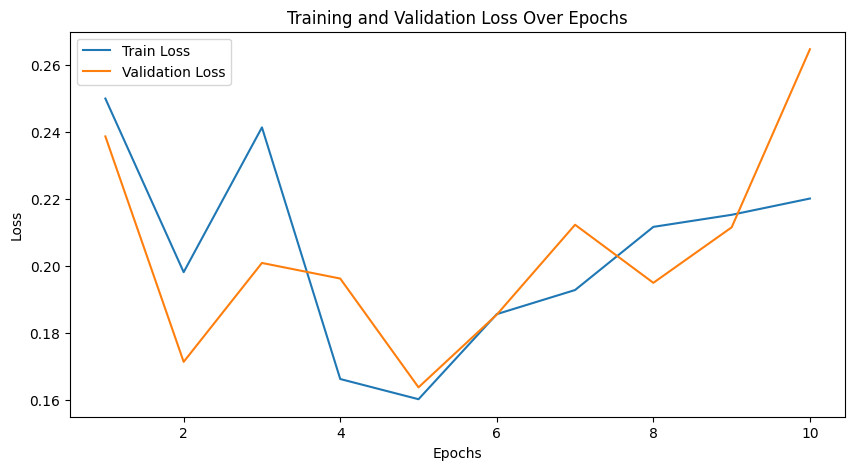

In [ ]:
!mkdir -p checkpoint

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Define LSTM-based model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)  # out: [batch_size, seq_len, hidden_size]
        out = self.fc(out[:, -1, :])  # Use the last time step's output
        return out

# Model parameters
input_size = len(features)  # Number of features (e.g., oxygen_ppm)
hidden_size = 32
output_size = 2  # Binary classification (normal/abnormal)
num_layers = 1
epochs = 20
learning_rate = 0.001
best_val_loss = float('inf')
best_model_path = "checkpoint/best_lstm_model.pth"

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the model, define loss function and optimizer
model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler to reduce learning rate if validation loss does not improve
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Early stopping parameters
early_stop_patience = 5
no_improvement_count = 0

# Lists to store loss values for plotting
train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Add tqdm for training progress visualization
    train_loader_tqdm = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{epochs}] Training")
    for batch_sequences, batch_labels in train_loader_tqdm:
        batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_sequences)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == batch_labels).sum().item()
        total_predictions += batch_labels.size(0)

    # Calculate training loss and accuracy
    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        val_loader_tqdm = tqdm(val_dataloader, desc=f"Epoch [{epoch+1}/{epochs}] Validation")
        for batch_sequences, batch_labels in val_loader_tqdm:
            batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)
            outputs = model(batch_sequences)
            loss = criterion(outputs, batch_labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == batch_labels).sum().item()
            total_predictions += batch_labels.size(0)

    # Calculate validation loss and accuracy
    val_epoch_loss = val_loss / len(val_dataloader)
    val_epoch_accuracy = correct_predictions / total_predictions
    val_losses.append(val_epoch_loss)
    print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

    # Save the best model based on validation loss
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")
        print("===============================================================================================")
        no_improvement_count = 0  # Reset early stopping counter
    else:
        no_improvement_count += 1

    # Reduce learning rate if validation loss does not improve
    scheduler.step(val_epoch_loss)

    # Early stopping check
    if no_improvement_count >= early_stop_patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


# 검증

<ipython-input-58-51a7a6b51a96>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Loaded the best model for testing.


Testing: 100%|██████████| 536/536 [00:02<00:00, 208.32it/s]


Test Loss: 0.1686, Test Accuracy: 0.9375


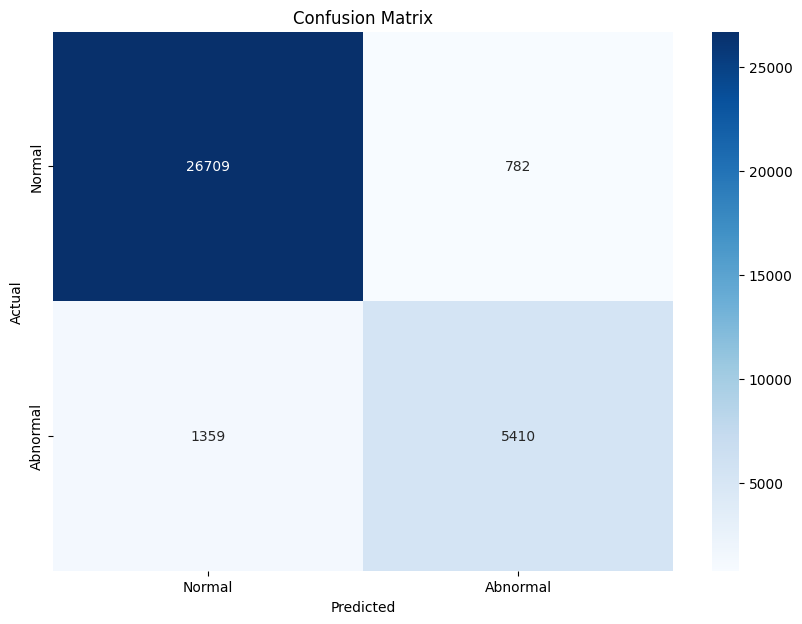

Classification Report:
               precision    recall  f1-score   support

      Normal       0.95      0.97      0.96     27491
    Abnormal       0.87      0.80      0.83      6769

    accuracy                           0.94     34260
   macro avg       0.91      0.89      0.90     34260
weighted avg       0.94      0.94      0.94     34260



In [ ]:
# 검증 코드
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch

# Testing loop
all_labels = []
all_predictions = []
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
model.eval()  # Set the model to evaluation mode

# Load the best model for testing
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path))
    print("Loaded the best model for testing.")

with torch.no_grad():  # No need to compute gradients during testing
    test_loader_tqdm = tqdm(test_dataloader, desc="Testing")
    for batch_sequences, batch_labels in test_loader_tqdm:
        batch_sequences, batch_labels = batch_sequences.to(device), batch_labels.to(device)

        # Forward pass
        outputs = model(batch_sequences)
        loss = criterion(outputs, batch_labels)
        test_loss += loss.item()

        # Get predictions
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == batch_labels).sum().item()
        total_predictions += batch_labels.size(0)

        # Collect labels and predictions for evaluation
        all_labels.extend(batch_labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate test loss and accuracy
test_epoch_loss = test_loss / len(test_dataloader)
test_epoch_accuracy = correct_predictions / total_predictions
print(f"Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_epoch_accuracy:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(all_labels, all_predictions, target_names=['Normal', 'Abnormal'])
print("Classification Report:\n", class_report)
